# FSI problem

In [1]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "FallingCylinder";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [109]:
2*2/1.57

2.5477707006369426

In [110]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 2.55)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,1.0,0.0,2.0], zeros(Float64,6), 0, [dofₚ], [0.0])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 1.0, 0.0, 2.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [111]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [112]:
bd, soln₀ = InitSystem!(bd)

(, Soln{Float64}(0.0, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[], Float64[]))

This is a 1 body-joint system, system is un-mounted from space

#### Initialize u and λ container

In [113]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [114]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

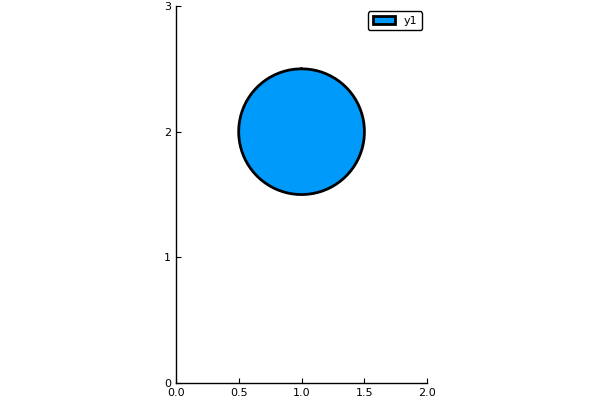

In [115]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,2), ylims=(0,3),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [116]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)
# U∞ = (U, 0.0)

(0.0, 0.0)

#### Set the domain grid

In [117]:
nx = 102; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [118]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [119]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [120]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,3]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,3]]]
end

#### Set up body grid points and force container in fluid

In [121]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [122]:
tf = 200Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

In [123]:
function TimeMarching.F(bd::BodyDyn)
    f_exi = zeros(Float64,bd.sys.nbody,6)
    return HERKFuncf(bd.bs, bd.js, bd.sys, f_exi, "cylinder", config_body.ρ)
end

In [124]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx,"cylinder"),
                 (bd,bgs,u) -> T₂(bd,bgs,u,"cylinder"),
                 (bd,bgs) -> getX̃(bd,bgs,"cylinder")),
                ((w,t) -> r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

 19.692142 seconds (189.75 M allocations: 6.178 GiB, 6.77% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [125]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [126]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is ",t)
end

 19.536524 seconds (188.52 M allocations: 6.116 GiB, 6.72% gc time)
next time unit is 0.01
 18.967904 seconds (187.63 M allocations: 6.076 GiB, 6.83% gc time)
next time unit is 0.02
 18.956982 seconds (187.63 M allocations: 6.076 GiB, 6.85% gc time)
next time unit is 0.03
 19.068221 seconds (187.63 M allocations: 6.076 GiB, 6.87% gc time)
next time unit is 0.04
 18.943951 seconds (187.63 M allocations: 6.076 GiB, 7.34% gc time)
next time unit is 0.05
 19.438184 seconds (187.63 M allocations: 6.076 GiB, 6.98% gc time)
next time unit is 0.060000000000000005
 19.786981 seconds (187.63 M allocations: 6.076 GiB, 6.92% gc time)
next time unit is 0.07
 18.862925 seconds (187.63 M allocations: 6.076 GiB, 7.01% gc time)
next time unit is 0.08
 19.367480 seconds (187.63 M allocations: 6.076 GiB, 7.03% gc time)
next time unit is 0.09
 20.569241 seconds (187.63 M allocations: 6.076 GiB, 7.06% gc time)
next time unit is 0.09999999999999999
 19.933707 seconds (187.63 M allocations: 6.076 GiB, 7.60% 

 20.202782 seconds (187.63 M allocations: 6.076 GiB, 7.15% gc time)
next time unit is 0.8100000000000005
 19.776386 seconds (187.63 M allocations: 6.076 GiB, 6.91% gc time)
next time unit is 0.8200000000000005
 20.355059 seconds (187.63 M allocations: 6.076 GiB, 6.85% gc time)
next time unit is 0.8300000000000005
 21.465554 seconds (187.63 M allocations: 6.076 GiB, 6.94% gc time)
next time unit is 0.8400000000000005
 19.963320 seconds (187.63 M allocations: 6.076 GiB, 7.32% gc time)
next time unit is 0.8500000000000005
 20.063284 seconds (187.63 M allocations: 6.076 GiB, 6.96% gc time)
next time unit is 0.8600000000000005
 19.942621 seconds (187.63 M allocations: 6.076 GiB, 6.80% gc time)
next time unit is 0.8700000000000006
 19.595995 seconds (187.63 M allocations: 6.076 GiB, 6.87% gc time)
next time unit is 0.8800000000000006
 19.915552 seconds (187.63 M allocations: 6.076 GiB, 6.83% gc time)
next time unit is 0.8900000000000006
 19.745739 seconds (187.63 M allocations: 6.076 GiB, 7.

 19.739242 seconds (187.63 M allocations: 6.076 GiB, 6.97% gc time)
next time unit is 1.6000000000000012
 19.634796 seconds (187.63 M allocations: 6.076 GiB, 6.84% gc time)
next time unit is 1.6100000000000012
 20.031322 seconds (187.63 M allocations: 6.076 GiB, 6.75% gc time)
next time unit is 1.6200000000000012
 19.985900 seconds (187.63 M allocations: 6.076 GiB, 7.10% gc time)
next time unit is 1.6300000000000012
 20.018963 seconds (187.63 M allocations: 6.076 GiB, 6.84% gc time)
next time unit is 1.6400000000000012
 19.883771 seconds (187.63 M allocations: 6.076 GiB, 7.25% gc time)
next time unit is 1.6500000000000012
 20.008609 seconds (187.63 M allocations: 6.076 GiB, 6.98% gc time)
next time unit is 1.6600000000000013
 19.907225 seconds (187.63 M allocations: 6.076 GiB, 6.86% gc time)
next time unit is 1.6700000000000013
 19.873537 seconds (187.63 M allocations: 6.076 GiB, 6.83% gc time)
next time unit is 1.6800000000000013
 19.891081 seconds (187.63 M allocations: 6.076 GiB, 6.

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [127]:
contour_levels = range(-0.2,stop=0.2,length=50)
sample_freq = 1
fps = 25;

#### Get body verts history

In [128]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end

#### Plot first and last time field

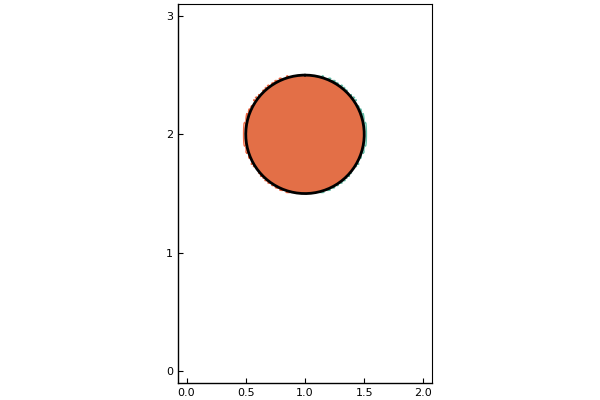

In [129]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="black", fill=true)
end
p

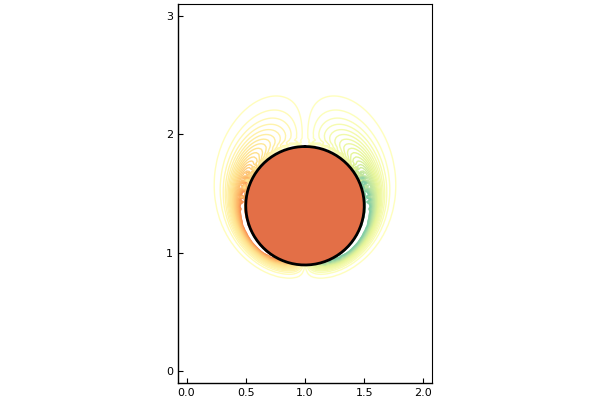

In [130]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

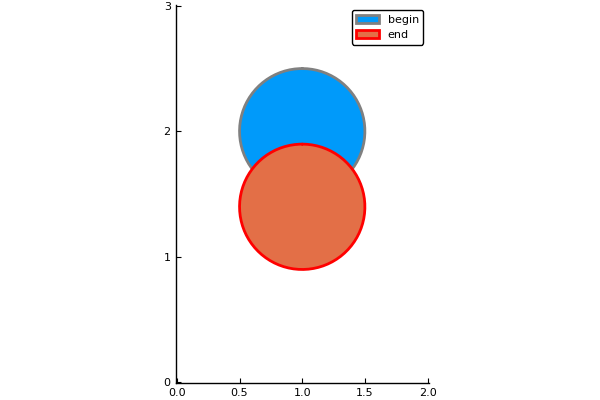

In [131]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make gif

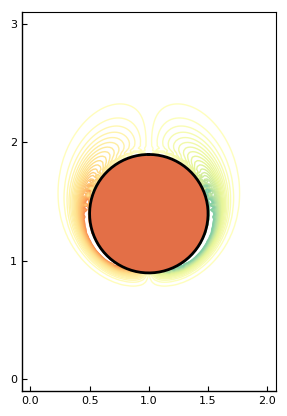

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/FallingCylinder.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/FallingCylinder.gif")

In [132]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,[1:nverts;1],1], vshist[j][i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [133]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

#### Plot

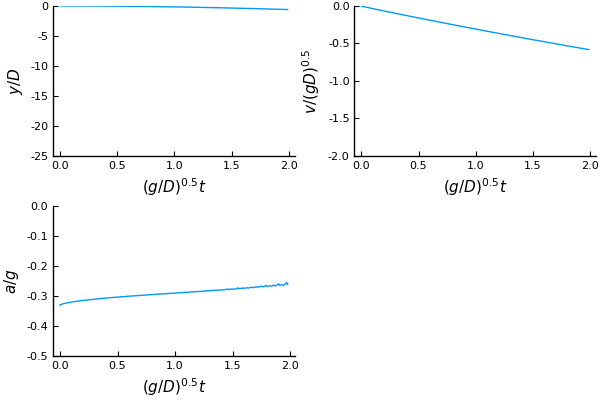

In [134]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,ylims=(-25,0))
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,ylims=(-2,0))
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,ylims=(-0.5,0))

plot(pp,pv,pa)

In [135]:
ahist

200-element Array{Any,1}:
 -0.3313400219234709 
 -0.3296420044094896 
 -0.32824447259257855
 -0.3270481611999299 
 -0.3259935419468641 
 -0.32504340618248473
 -0.32417275534482454
 -0.3233647528643288 
 -0.3226037631088582 
 -0.32188185024301025
 -0.3211905282846386 
 -0.3205245085081798 
 -0.3198791222140826 
  ⋮                  
 -0.2669045897514599 
 -0.2641503652045518 
 -0.2633314573374457 
 -0.2594890499303282 
 -0.26490329818256164
 -0.2625551875120813 
 -0.2628617740608741 
 -0.2658926366185477 
 -0.2616708015621638 
 -0.260397137322399  
 -0.25530908922168916
 -0.26248552414446236

#### fluid force

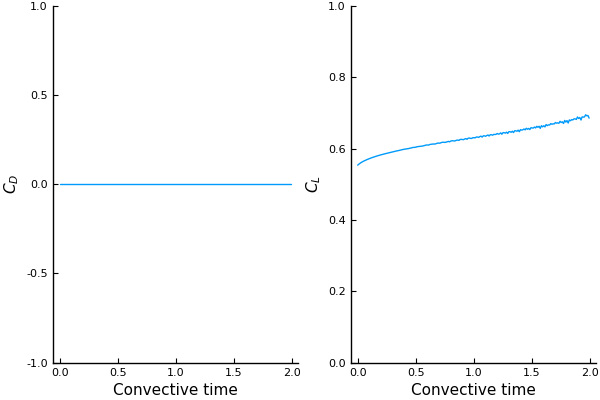

In [136]:
px = plot(thist,fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,fy,ylim=(0,1),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

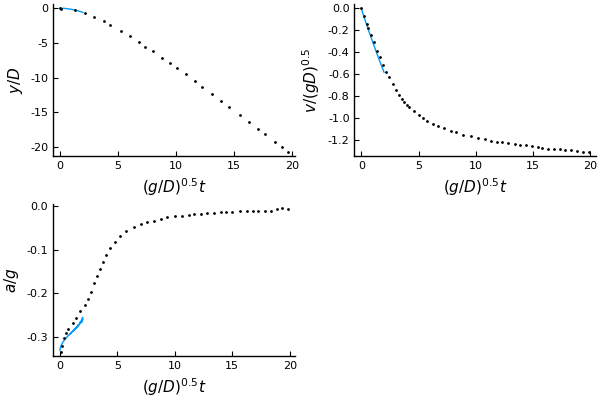

In [139]:
using CSV

pdata = CSV.read("local_run/validation/csv/position.csv",header=false)
xp = [pdata[i,1] for i in 1:length(pdata[1])]
yp = [pdata[i,2] for i in 1:length(pdata[2])]

vdata = CSV.read("local_run/validation/csv/velocity.csv",header=false)
xv = [vdata[i,1] for i in 1:length(vdata[1])]
yv = [vdata[i,2] for i in 1:length(vdata[2])]

adata = CSV.read("local_run/validation/csv/acceleration.csv",header=false)
xa = [adata[i,1] for i in 1:length(adata[1])]
ya = [adata[i,2] for i in 1:length(adata[2])];

pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false)#,ylims=(-25,0))
scatter!(pp,xp,yp,linestyle=:dot,markersize=1)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false)#,ylims=(-2,0))
scatter!(xv,yv,linestyle=:dot,markersize=1)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false)#,ylims=(-0.5,0))
scatter!(xa,ya,linestyle=:dot,markersize=1)

plot(pp,pv,pa)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [137]:
using JLD
save(filename*".jld",
    "bd", bd,    
    "bdhist", bdhist,
    "xg", xg,
    "yg", yg,
    "whist", whist,
    "vshist", vshist,
    "thist", thist,
    "fx", fx,
    "fy", fy,
    "Δt", Δt,
    "w", w,
    "qJ", qJ,
    "v", v
)

#### Use the following block to extract data

In [138]:
# using JLD

# d = load(filename*".jld")
# thist = d["thist"]
# fx = d["fx"]
# fy = d["fy"]
# xg = d["xg"]
# yg = d["yg"]
# vshist = d["vshist"]
# whist = d["whist"]
# bd = d["bd"]
# bdhist = d["bdhist"]
# Δt = d["Δt"]
# w = d["w"]
# qJ = d["qJ"]
# v = d["v"]

# @get bd (bs,js,sys);